In [1]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy

import warnings
warnings.filterwarnings("ignore")

### Load data
Note the data files needed are large, and can be generated by the cells supplied in the experiement notebook. However, these will take some time to generate. One can therefore reduce the number of runs needed and use those instead.

In [2]:
if False:
    #BCNN and SNPE-C results
    ID = 'data'
        
    ## SNPE-C
    sbi_post = np.load(f'{ID}/sbi_{ID}_post.npy')
    sbi_time = np.load(f'{ID}/sbi_{ID}_time.npy')
    
    ## BCNN
    bcnn_post = np.load(f'{ID}/bcnn_{ID}_post.npy') 
    bcnn_time = np.load(f'{ID}/bcnn_{ID}_time.npy')

else:
    ## SNPE-C
    sbi_post = np.load(f'SBI_10_10gen_large_sample.npy')
    sbi_time = np.load('SBI_10_10gen_large_sample_times.npy')
    sbi_post = sbi_post[:5,:8,:,:]
    sbi_time = sbi_time[:5,:8]
    
    ## BCNN
    bcnn_post = np.load('bnn_res_5_5round_8gen_theta_thresh.npy')
    bcnn_time = np.load('bnn_res_5_5round_8gen_time_thresh.npy')
    
bcnn_post = bcnn_post[:,1:,:,:] # first sample is simply from prior, remove.
    
## ABC-SMC
smc_post = np.load('smcabc_posterior_5gen.npy',allow_pickle=True)
Y = np.empty(shape=(5,8,1000,3))
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        Y[i,j,:,:] = smc_post[i][j][:1000][:]
smc_post = Y
smc_time = np.load('smcabc_posterior_5gen_time.npy')



# Main paper figures

### Compute mean and std

In [3]:
sbi_post_mean = sbi_post.mean(axis=2)
sbi_post_std = sbi_post.std(axis=2)

sbi_time_mean = sbi_time.mean(axis=0)
sbi_time_std = sbi_time.std(axis=0)

bcnn_post_mean = bcnn_post.mean(axis=2)
bcnn_post_std = bcnn_post.std(axis=2)

bcnn_time_mean = bcnn_time.mean(axis=0)
bcnn_time_std = bcnn_time.std(axis=0)

smc_post_mean = np.mean(smc_post, axis=2)
smc_post_std = np.std(smc_post, axis=2)

### Compute the MSE

In [4]:
theta_true = np.log([[1.0,0.005, 1.0]])
theta_ = np.expand_dims(theta_true,axis=[0,1])

sbi_post_mse = ((theta_ - sbi_post)**2).mean(axis=(2,3))
bcnn_post_mse = ((theta_ - bcnn_post)**2).mean(axis=(2,3))
smc_post_mse = ((theta_ - smc_post)**2).mean(axis=(2,3))

## Figure 4 - MSE of BNN, SNPE-C, and ABC-SMC

In [5]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

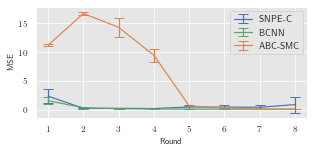

In [6]:
sns.set_theme()

font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})



f = plt.figure(figsize=(4.25, 2), constrained_layout=True)
gs = f.add_gridspec(1, 1)

#Theta 1,2,3 mse(<post>)
ax = f.add_subplot(gs[0, 0])
ax.errorbar(x=np.arange(8)+1, y=sbi_post_mse.mean(axis=0)[:], 
            yerr=sbi_post_mse.std(axis=0)[:], 
            capsize=5, color='C0', label='SNPE-C')
ax.errorbar(x=np.arange(8)+1, y=bcnn_post_mse.mean(axis=0)[:], 
            yerr=bcnn_post_mse.std(axis=0)[:],
            capsize=5, color='C2', label='BCNN')
ax.errorbar(x=np.arange(8)+1, y=smc_post_mse.mean(axis=0)[:], 
            yerr=smc_post_mse.std(axis=0)[:],
            capsize=5, color='C1', label='ABC-SMC')
ax.set_ylabel('MSE')
ax.set_xlabel('Round')

plt.legend(loc='upper right')
#plt.yscale('log')

#plt.savefig('lv_mse.pdf',dpi=350, bbox_inches = 'tight', pad_inches = 0)

## Figure 5 -  Snapshot of $p(\theta | D)$

In [7]:

def posterior_snaps(run_idx=0, save=True):  
    
    def multivar(grid, x, y, xlabel='', ylabel='', label='',color='C0'):
        ax = f.add_subplot(grid)
        sns.kdeplot(x=x, y=y, ax=ax, label=label,color=color)
        ax.set_ylim(np.log(0.002),np.log(2))
        ax.set_xlim(np.log(0.002),np.log(2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax

    def singlevar(grid, x, y, xlabel='', ylabel='', label='',color='C0'):
        ax = f.add_subplot(grid)
        ax.plot(x, y, marker='x', ms=5, label=label,color=color)
        ax.set_ylim(np.log(0.002),np.log(2))
        ax.set_xlim(np.log(0.002),np.log(2))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return ax


    font_size = 8
    sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    f = plt.figure(figsize=(4.25, 4.25), constrained_layout=True)

    widths =  [1, 1, 1]# 1, 1, 1, 1, 1]
    heights = [1, 1, 1]#, 1, 1, 1, 1, 1, 1]
    gs = f.add_gridspec(3,3, width_ratios=widths, height_ratios=heights)
    # k1 x k2

    ax = multivar(gs[0, 0],x=smc_post[run_idx, 1, :, 1], y=smc_post[run_idx, 1, :, 0],ylabel=r'$(\theta_2, \theta_1)$',color='C1')
    ax = multivar(gs[0, 1],x=smc_post[run_idx, 3, :, 1], y=smc_post[run_idx, 3, :, 0],color='C1')
    ax = multivar(gs[0, 2],x=smc_post[run_idx, 7, :, 1], y=smc_post[run_idx, 7, :, 0], label='ABC-SMC',color='C1')

    ax = multivar(gs[0, 0],x=bcnn_post[run_idx, 1, :, 1], y=bcnn_post[run_idx, 1, :, 0],ylabel=r'$(\theta_2, \theta_1)$',color='C2')
    ax = multivar(gs[0, 1],x=bcnn_post[run_idx, 3, :, 1], y=bcnn_post[run_idx, 3, :, 0],color='C2')
    ax = multivar(gs[0, 2],x=bcnn_post[run_idx, 7, :, 1], y=bcnn_post[run_idx, 7, :, 0],label='BCNN',color='C2')

    ax = multivar(gs[0, 0],x=sbi_post[run_idx, 1, :, 1], y=sbi_post[run_idx, 1, :, 0],ylabel=r'$(\theta_2, \theta_1)$',color='C0')
    ax = multivar(gs[0, 1],x=sbi_post[run_idx, 3, :, 1], y=sbi_post[run_idx, 3, :, 0],color='C0')
    ax = multivar(gs[0, 2],x=sbi_post[run_idx, 7, :, 1], y=sbi_post[run_idx, 7, :, 0], label='SNPE-C',color='C0')

    ax = singlevar(gs[0, 0],x=theta_true[0,1],y=theta_true[0,0],color='C3',ylabel=r'$(\theta_2, \theta_1)$')
    ax = singlevar(gs[0, 1],x=theta_true[0,1],y=theta_true[0,0],color='C3')
    ax = singlevar(gs[0, 2],x=theta_true[0,1],y=theta_true[0,0],color='C3',label='truth')





    ax.legend(loc='lower right')

    # k1 x k3

    ax = multivar(gs[1, 0],x=smc_post[run_idx, 1, :, 2], y=smc_post[run_idx, 1, :, 0],ylabel=r'$(\theta_3, \theta_1)$',color='C1')
    ax = multivar(gs[1, 1],x=smc_post[run_idx, 3, :, 2], y=smc_post[run_idx, 3, :, 0],color='C1')
    ax = multivar(gs[1, 2],x=smc_post[run_idx, 7, :, 2], y=smc_post[run_idx, 7, :, 0], label='ABC-SMC',color='C1')

    ax = multivar(gs[1, 0],x=bcnn_post[run_idx, 1, :, 2], y=bcnn_post[run_idx, 1, :, 0],ylabel=r'$(\theta_3, \theta_1)$',color='C2')
    ax = multivar(gs[1, 1],x=bcnn_post[run_idx, 3, :, 2], y=bcnn_post[run_idx, 3, :, 0],color='C2')
    ax = multivar(gs[1, 2],x=bcnn_post[run_idx, 7, :, 2], y=bcnn_post[run_idx, 7, :, 0],color='C2')

    ax = multivar(gs[1, 0],x=sbi_post[run_idx, 1, :, 2], y=sbi_post[run_idx, 1, :, 0],ylabel=r'$(\theta_3, \theta_1)$', color='C0')
    ax = multivar(gs[1, 1],x=sbi_post[run_idx, 3, :, 2], y=sbi_post[run_idx, 3, :, 0], color='C0')
    ax = multivar(gs[1, 2],x=sbi_post[run_idx, 7, :, 2], y=sbi_post[run_idx, 7, :, 0], color='C0')

    ax = singlevar(gs[1, 0],x=theta_true[0,2],y=theta_true[0,0],color='C3',ylabel=r'$(\theta_3, \theta_1)$')
    ax = singlevar(gs[1, 1],x=theta_true[0,2],y=theta_true[0,0],color='C3')
    ax = singlevar(gs[1, 2],x=theta_true[0,2],y=theta_true[0,0],color='C3',label='truth')


    # k2 x k3


    ax = multivar(gs[2, 0],x=smc_post[run_idx, 1, :, 2], y=smc_post[run_idx, 1, :, 1], xlabel='Round 2',ylabel=r'$(\theta_3, \theta_2)$',color='C1')
    ax = multivar(gs[2, 1],x=smc_post[run_idx, 3, :, 2], y=smc_post[run_idx, 3, :, 1], xlabel='Round 2',color='C1')
    ax = multivar(gs[2, 2],x=smc_post[run_idx, 7, :, 2], y=smc_post[run_idx, 7, :, 1], xlabel='Round 2', label='ABC-SMC',color='C1')


    ax = multivar(gs[2, 0],x=bcnn_post[run_idx, 1, :, 2], y=bcnn_post[run_idx, 1, :, 1],xlabel='Round 2',ylabel=r'$(\theta_3, \theta_2)$',color='C2')
    ax = multivar(gs[2, 1],x=bcnn_post[run_idx, 3, :, 2], y=bcnn_post[run_idx, 3, :, 1],xlabel='Round 4',color='C2')
    ax = multivar(gs[2, 2],x=bcnn_post[run_idx, 7, :, 2], y=bcnn_post[run_idx, 7, :, 1],xlabel='Round 8',color='C2')


    ax = multivar(gs[2, 0],x=sbi_post[run_idx, 1, :, 2], y=sbi_post[run_idx, 1, :, 1], xlabel='Round 2',ylabel=r'$(\theta_3, \theta_2)$', color='C0')
    ax = multivar(gs[2, 1],x=sbi_post[run_idx, 3, :, 2], y=sbi_post[run_idx, 3, :, 1], xlabel='Round 4', color='C0')
    ax = multivar(gs[2, 2],x=sbi_post[run_idx, 7, :, 2], y=sbi_post[run_idx, 7, :, 1], xlabel='Round 8', color='C0')


    ax = singlevar(gs[2, 0],x=theta_true[0,2],y=theta_true[0,1],color='C3',xlabel='Round 2',ylabel=r'$(\theta_3, \theta_2)$')
    ax = singlevar(gs[2, 1],x=theta_true[0,2],y=theta_true[0,1],color='C3',xlabel='Round 4')
    ax = singlevar(gs[2, 2],x=theta_true[0,2],y=theta_true[0,1],color='C3',label='truth',xlabel='Round 8')

    if save:
        plt.savefig(f'lv_dens_{run_idx}.pdf',dpi=350, bbox_inches = 'tight', pad_inches = 0)



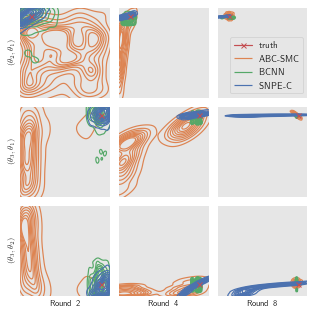

In [8]:
posterior_snaps(run_idx=0,save=False) 

## Supplemental figures 

### Figure S8 - multiple runs of the inference procedure with different number seeds

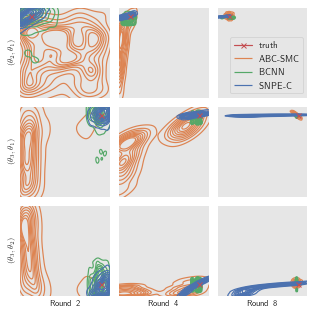

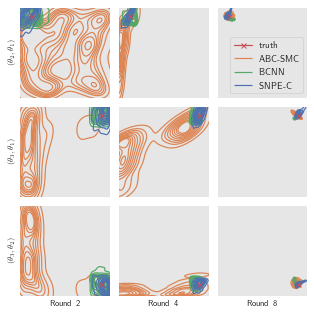

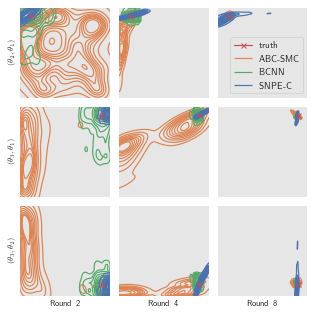

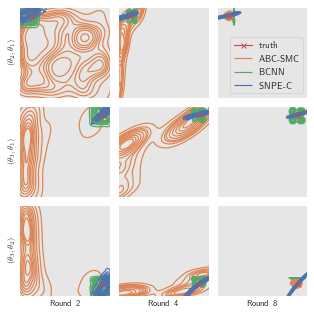

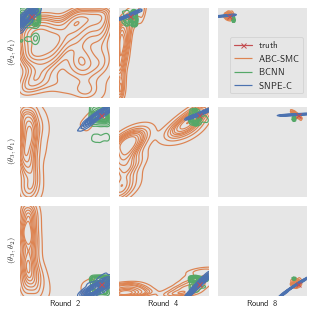

In [9]:
for i in range(bcnn_post.shape[0]):
    posterior_snaps(run_idx=i,save=False) 

### Figure S5 - impact of # of classes (bins$^2$)

In [10]:
bcnn3 = np.load('bnn_res_3_5round_8gen_theta_thresh.npy')
bcnn4 = np.load('bnn_res_4_5round_8gen_theta_thresh.npy')
bcnn5 = np.load('bnn_res_5_5round_8gen_theta_thresh.npy')

In [11]:
bcnn3_mse = ((theta_ - bcnn3)**2).mean(axis=(2,3))
bcnn4_mse = ((theta_ - bcnn4)**2).mean(axis=(2,3))
bcnn5_mse = ((theta_ - bcnn5)**2).mean(axis=(2,3))

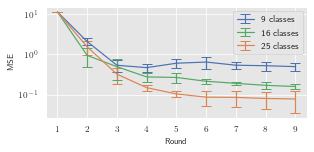

In [12]:
sns.set_theme()

font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})



f = plt.figure(figsize=(4.25, 2), constrained_layout=True)
gs = f.add_gridspec(1, 1)

#Theta 1,2,3 mse(<post>)
ax = f.add_subplot(gs[0, 0])
ax.errorbar(x=np.arange(9)+1, y=bcnn3_mse.mean(axis=0)[:], 
            yerr=bcnn3_mse.std(axis=0)[:], 
            capsize=5, color='C0', label='9 classes')
ax.errorbar(x=np.arange(9)+1, y=bcnn4_mse.mean(axis=0)[:], 
            yerr=bcnn4_mse.std(axis=0)[:],
            capsize=5, color='C2', label='16 classes')
ax.errorbar(x=np.arange(9)+1, y=bcnn5_mse.mean(axis=0)[:], 
            yerr=bcnn5_mse.std(axis=0)[:],
            capsize=5, color='C1', label='25 classes')
ax.set_ylabel('MSE')
ax.set_xlabel('Round')
plt.yscale('log')
plt.legend(loc='upper right')

#plt.savefig('lv_bins.pdf',dpi=350, bbox_inches = 'tight', pad_inches = 0)

### Figure S6 - threshold or not

In [13]:
bcnn5_no = np.load('bnn_res_5_5round_8gen_theta.npy')
bcnn5_no_mse = ((theta_ - bcnn5_no)**2).mean(axis=(2,3))

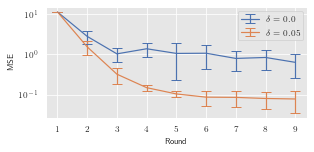

In [14]:
sns.set_theme()


font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})



f = plt.figure(figsize=(4.25, 2), constrained_layout=True)
gs = f.add_gridspec(1, 1)

#Theta 1,2,3 mse(<post>)
ax = f.add_subplot(gs[0, 0])
ax.errorbar(x=np.arange(9)+1, y=bcnn5_no_mse.mean(axis=0)[:], 
            yerr=bcnn5_no_mse.std(axis=0)[:],
            capsize=5, color='C0', label='$\delta = 0.0$')
ax.errorbar(x=np.arange(9)+1, y=bcnn5_mse.mean(axis=0)[:], 
            yerr=bcnn5_mse.std(axis=0)[:],
            capsize=5, color='C1', label='$\delta = 0.05$')
ax.set_ylabel('MSE')
ax.set_xlabel('Round')
plt.yscale('log')
plt.legend(loc='upper right')

#plt.savefig('lv_thresh.pdf',dpi=350, bbox_inches = 'tight', pad_inches = 0)

### Figure S7 - Elapsed time

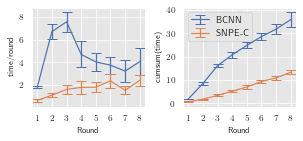

In [15]:
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

sns.set_theme()
font_size = 8
sns.set_context("paper", rc={"font.size":font_size,"axes.titlesize":font_size,"axes.labelsize":font_size, "axis.legendsize":font_size })
sns.set_style("darkgrid", {"axes.facecolor": ".9"})


f = plt.figure(figsize=(4.25, 2))
gs = f.add_gridspec(1, 2)

#Theta 1 E(<post>)
ax = f.add_subplot(gs[0, 0])

ax.errorbar(x=np.arange(8)+1, y=bcnn_time.mean(axis=0)/60, 
            yerr=bcnn_time.std(axis=0)/60, 
            capsize=5, color='C0', label='BCNN')
ax.errorbar(x=np.arange(8)+1, y=sbi_time.mean(axis=0)/60, 
            yerr=sbi_time.std(axis=0)/60, 
            capsize=5, color='C1', label='SNPE')
ax.set_xlabel("Round")
ax.set_ylabel("time/round")
ax.set_xticks(np.arange(8)+1)

ax = f.add_subplot(gs[0, 1])

bcnn_cumsum = np.cumsum(bcnn_time, axis=1)
sbi_cumsum = np.cumsum(sbi_time, axis=1)
ax.errorbar(x=np.arange(8)+1, y=bcnn_cumsum.mean(axis=0)/60, 
            yerr=bcnn_cumsum.std(axis=0)/60, 
            capsize=5, color='C0', label='BCNN')
ax.errorbar(x=np.arange(8)+1, y=sbi_cumsum.mean(axis=0)/60, 
            yerr=sbi_cumsum.std(axis=0)/60, 
            capsize=5, color='C1', label='SNPE-C')

ax.set_xlabel("Round")
ax.set_ylabel("cumsum(time)")
ax.set_xticks(np.arange(8)+1)


plt.legend()
plt.tight_layout()

#plt.savefig('lv_time.pdf',dpi=350, bbox_inches = 'tight', pad_inches = 0)

# posterior predictive

In [ ]:
def findQuantile(x, alpha=0.05):
    """Find the quantile in the Bayesian distribution
    
    params
        x: the observed data
        alpha: percentiles, e.g., 0.05
    """
    xs = np.sort(x, axis=0)
    cpxx = np.cumsum(xs, axis=0) / np.sum(xs, axis=0)

    upper = 1-alpha/2
    lower = 1-upper
    low = []
    up = []
    for i in range(xs.shape[1]):
        low.append(xs[np.where(cpxx >= lower)[0][0],i])
        up.append(xs[np.where(cpxx >= upper)[0]-1,i][0])

    return low, up

def plot_trajs(new_data, target_original_shape, save=False):
    
    
    fig, ax = plt.subplots(1,2, facecolor = 'w', edgecolor = 'w')
    for i in range(len(new_data)):
        if i == 0:
            ax[0].plot(new_data[i,0,:], color = 'C0', alpha = 0.1, label="Posterior sample")
            ax[1].plot(new_data[i,1,:], color = 'C0', alpha = 0.1, label="Posterior sample")
        else:
            ax[0].plot(new_data[i,0,:], color = 'C0', alpha = 0.1)
            ax[1].plot(new_data[i,1,:], color = 'C0', alpha = 0.1)
            
    data_mean = np.mean(new_data,axis=0)
    data_95_0 = findQuantile(new_data[:,0,:], alpha=0.5)
    data_95_1 = findQuantile(new_data[:,1,:], alpha=0.5)


    ax[0].plot(data_mean[0,:], color = 'red', label = 'Posterior mean')
    ax[0].plot(data_95_0[0], linestyle='dashed', color = 'red', label = '50% CR')
    ax[0].plot(data_95_0[1], linestyle='dashed', color = 'red')


    ax[1].plot(data_mean[1,:], color = 'red', label = 'Posterior mean')
    ax[1].plot(data_95_1[0], linestyle='dashed', color = 'red', label = '50% CR')
    ax[1].plot(data_95_1[1], linestyle='dashed', color = 'red')
    
    x_dim = np.arange(0,target_original_shape.shape[2])
    ax[0].plot(x_dim, target_original_shape[0,0,:], 'kx', label = 'Observed Data')
    ax[1].plot(x_dim, target_original_shape[0,1,:], 'kx', label = 'Observed Data')
    
    
    ax[0].set_title("Prey",fontsize=16)
    ax[1].set_title("Predator",fontsize=16)
    ax[0].set_ylabel("Count",fontsize=16)

    for j in range(2):
        ax[j].set_xlabel("Time", fontsize=16)
        ax[j].legend(fontsize=16)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['top'].set_visible(False)

    fig.set_size_inches(18, 8)
    if not save:
        plt.show()

In [ ]:
data_post_ts, data_post_thetas = newData(result_posterior[0][-1][::25,:], toexp=True)
plot_trajs(data_post_ts, target_original_shape_ts, save=False)